## An Analysis of IP Address Census of ANT ISI dataset  


## Introduction  
IP Address censuses are useful in understanding IP address space utilization. Several tools and papers propose techniques using active [], passive [] measurements or a combination of both. Active measurements typically make use of PING as one of the tools in the census. An address is considered allocated if a response is received from the probed host.   
ANT ISI dataset(s) builds on the active measurement technique. Over a period of 10 weeks (?), the entire IPv4 address space is probed and the PING responses are stored. These responses have been collected at regular interval, starting in 2010(?), and at the time of writing this reports, over 85 surveys have been conducted. One of the by-products of these surveys is the address history dataset [], which contains the PING responses of over 1.4 billion IP addresses over the 12 year period.   
In this project we hope to understand the coverage of /24s in the ANT ISI datasets, and how the responsiveness of hosts to PING has evolved over time. We also wish to investigate if there is potential in considering other sources of data for measuring address space utilization, since many networks are configured not to respond to PINGS [?], but will respond to TCP/HTTP requests.     
A different source of address space utilization is the data collected in internet-wide scans, with tools such as ZMap []. Censys[] conducts periodic scans of the IPv4 address space using a suite of protocol handshakes such as TLS, POP3 etc. These protocol handshakes help us in addressing the issue of discovering hosts in networks configured to block PINGs.  
In summary, we investigate the potential of supplementing PING with other protocol handshakes for the purpose of measuring IP address space utilization.  



## Datasets  
In this section, we briefly describe the datasets used in the analysis: (1) ANT ISI IP History and (2) Censys Universal Internet Dataset.  
### ANT ISI IP History  
This dataset from University of Southern California summarizes the IP Census data as follows:  
For every IPv4 address probed, the dataset records the response in each survey conducted in a hexadecimal number. A 0 in the ith bit  of the hexadecimal number means that the PING to the host failed, and a 1 indicicates success. An example record would look like this:  
__1.2.3.4,F000F__   
This record contains several pieces of information:
    1. There were at least 20 surveys conducted (from the length of the hexadecimal converted to binary, we can infer that 4 bits * 5 digits can represent 20 surveys).  
    2. The address responded to four surveys, was undiscoverable for the next 12 surveys, and then again became discoverable in the following 4 surveys.  
The data is available from download on request from the ANT ISI website []. It has a text file, where each line corresponds to the IP respone history of one host. 
### Censys Universal Internet Dataset  
The Censys dataset contains the results of several protocol handshakes with millions of hosts, along with useful metadata information, like Host OS, software version etc. Censys provides raw data dumps in addition to exposing a BigQuery interface to query the collected data. Each records contains the response from several handshakes for a single host.  

## Dataset Processing    
Considering the disparity in the data formats, to enable easy querying and comparison of the data, first the ANT Dataset was ingested into BigQuery tables using the Python API.    
### Challenges in data processing  
The ANT ISI IP History dataset is 55 GB in size, and hard to fit in memory. It also holds data in a format that does not support easy analysis with SQL. So we first parse the dataset and convert it into the following format:  
__ipv4, ip\_history, survey0, survey1, survey2....__    
__1.2.3.4,F000F,1,1,1,1,0,0,0,0,0,0,...__  
Here, survey0, survey1 represent the response to the corresponding surveys.  


In [1]:
import dask.dataframe as dd
import matplotlib.pyplot as plt
import pandas as pd
import json

In [2]:
# load the dataset
df = dd.read_csv('internet_address_history_it95w-20210727.fsdb', sep='\t', dtype=str, header=None, skiprows=1, blocksize="10MB")
# name the columns sensibly
df.columns=['ip_hex', 'ip', 'history', 'score']
# make the string hex-comprehensible
df['history_hex'] = '0x' + df['history']

In [3]:
# veriy that the number of partitions and block size tally up with the dataset size
df.npartitions

5823

In [5]:

%%time
# create the new columns by mapping each bit in the hex string to a new column
def get_binary_str(df):
    return df['history'].apply(lambda x:int(x, 16))\
                                .apply(bin).str[2:] \
                                .apply(lambda x: x.zfill(85))
df['history_bin'] = df.map_partitions(get_binary_str, meta=('history', 'str'))

# we only need the new columns we create, so we can drop the old data
df = df.drop(['history', 'history_hex', 'ip_hex'], axis=1)
# Dask lazily loads data, so none of these operations are carried out when you run this cell :) 
# Only the computations are defined  

CPU times: user 11.4 ms, sys: 0 ns, total: 11.4 ms
Wall time: 19.1 ms


In [11]:
# uncomment to generate gzipped partitions. 
#df.to_csv('address_history/address_history-*.csv.gz', compression='gzip', index=False, header=False)

__Caution: This will take a really long time to run if you have an old machine. Uncomment the above cell to write out the processed data. Ideally run the cells above as a separate file__

Our short term goal is to make the data easily queryable, so we will move the data to Google BigQuery. We will also extract /24s from the IPv4 address and populate them into a separate BigQuery table. Similarly, we will gather Ipv4 addresses from Censys dataset and extract the /24 from those IPs as well.  
BigQuery has a 10MB limitation on csv uploads, and hence we had to do the whole exercise of creating partions of the data.   
Make sure you have a Google account, create a new project and generate an API Key to use for the project. You will need to grant permissions for the API key to query and write to your project. More instructions can be found here[].  

We will define the schema that we will use for BigQuery using our dataframe:


In [ ]:
dtypes = []
df['score'] = df['score'].astype(float)
df['ip'] = df['ip'].astype(str)
for d in dict(df.dtypes):
    if d=='ip' or d == 'history_bin':
        dtype = 'STRING'
        desc = d
        name = d
    elif d == 'score':
        dtype = 'FLOAT'
        desc = 'score'
        name = d
    else:
        dtype = 'INT64'
        desc = 'survey number ' + d
        name = 'survey_' + d
    dtypes.append({"description":desc, "mode":"REQUIRED", "type": dtype, "name":name})
with open('schema.json', 'w') as fh:
    json.dump(dtypes, fh, indent=4)

## BigQuery Writer Pipeline  
While we wait for Dask to write out the partitions, we can start uploading the data to BigQuery in parallel. Thusfar, our pipeline looks like this:  
![Data Processing and Querying Pipeline](pipeline.png)

In [14]:
from google.cloud import bigquery
import os
from google.oauth2 import service_account
import time
import json
import pandas as pd

In [9]:
project_id = 'censys-research-340718'
table_id = 'ant_isi_ip_history.ip_history'
data_dir = 'address_history'
## credentials file that you can download from your Google account
credentials = service_account.Credentials.from_service_account_file('creds.json')
client = bigquery.Client(credentials=credentials)

In [6]:
def get_schema(filename):
    with open(filename) as fh:
        schemajson = json.load(fh)
        schema = []
        for rec in schemajson:
            schema.append(bigquery.SchemaField(rec['name'], rec['type'], rec['mode']))
    print('schema has ', len(schema), 'columns')
    return schema


def create_table(schema):
    table = bigquery.Table(project_id + '.' + table_id, schema=schema)
    table = client.create_table(table)  # Make an API request.
    print(
        "Created table {}.{}.{}".format(table.project, table.dataset_id, table.table_id)
    )

def upload_data(schema):
    job_config = bigquery.LoadJobConfig(source_format=bigquery.SourceFormat.CSV, schema=schema)
    fail_list = []
    while True:
        files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if os.path.isfile(os.path.join(data_dir, f))]
        files.sort(key=lambda x: os.path.getmtime(x))
        if len(files) == 0:
            break
        print('got ', len(files), 'files')
        for f in files:
            try:    
                if f in fail_list:
                    continue
    
                print('processing', f)
                with open(f, 'rb') as source_file:
                    job = client.load_table_from_file(source_file, table_id,job_config=job_config)
                job.result()
                time.sleep(60)
                table = client.get_table(table_id)
                print('table now has ', table.num_rows, ' rows')
                print('removing file after processing ', f)
                os.remove(f)
            except:
                print(f, 'failed')
                fail_list.append(f)
                continue
    
    with open('fail.json', 'w') as fh:
        json.dump(fail_list, f)
 

In [10]:
schema = get_schema('schema.json')
## uncomment to start uploading data
#upload_data(schema)


schema has  88 columns


## Analysis  
We first do some basic statistics check on the IPv4 addresses in both datasets. We first try to find how many surveys an IP responds to. 
![IP Response](counts_big.png)

We then take a particular survey(corresponding to July 27, 2021), and we find:  
    - Number of unique IP addresses that responded to PING 
    - Number of unique /24s queried which had at least one PING response  
| Dataset     | Number of unique IPv4 | Number of unique /24s |
| ----------- | ----------------------|-----------------------|
| ANT ISI     | 386,418,466           | 5,091,179             |
| Censys      | 213,386,990           | 4,379,858             |

    

Next, we look at the coverage over time.  
    - Number of IPs discovered over time  
    - Number of subnets covered over time  
    - Change in coverage of subnets over time  

In [13]:
def get_responsive_subnets(client):
    results = []
    for i in range(MAX_SURVEYS):
        query = f'''select count(*) FROM(select s.ip_subnet
                FROM `censys-research-340718.ant_isi_ip_history.ip_history`a 
                JOIN `censys-research-340718.ant_isi_ip_history.subnets`s
                ON a.ip = s.ip 
                WHERE a.survey_{i} = 1
                GROUP  BY s.ip_subnet
                HAVING COUNT(a.survey_{i}) > 0)
            '''
        query_job = client.query(query)
        for row in query_job:
            results.append({'survey':i, 'count':row[0]})
    return results

def get_avg_ip_response(client):
    results =  []
    for i in range(MAX_SURVEYS):
        query = f'''select avg(count_ip) FROM(select count(a.ip) as count_ip
                FROM `censys-research-340718.ant_isi_ip_history.ip_history`a 
                JOIN `censys-research-340718.ant_isi_ip_history.subnets`s
                ON a.ip = s.ip 
                WHERE a.survey_{i} = 1
                GROUP  BY s.ip_subnet
                HAVING COUNT(a.survey_{i}) > 0)
            '''
        query_job = client.query(query)
        for row in query_job:
            results.append({'survey':i, 'count':row[0]})

    return results

In [15]:
# uncomment to run query
#responsive_subnets_by_survey = get_responsive_subnets(client)
#pd.write_csv(pd.DataFrame(responsive_subnets_by_survey), 'subnet_count.csv')
#avg_ip_count_by_subnet_by_survey = get_responsive_subnets(client)
#pd.write_csv(pd.DataFrame(avg_ip_count_by_subnet), 'avg_ip_count_in_subnet.csv')


### Number of /24s covered over time  
Note: Survey numbers increase with time.  
- Our main takeaway from the below two graphs is that the ANT ISI dataset covers in the recent years, about 5 million /24s, which is 30\% of the IPv4 address space. Within those /24s, the number of IPs averages close tp 70, or about the size of a /25. 

Text(0.5, 0, 'Survey #')

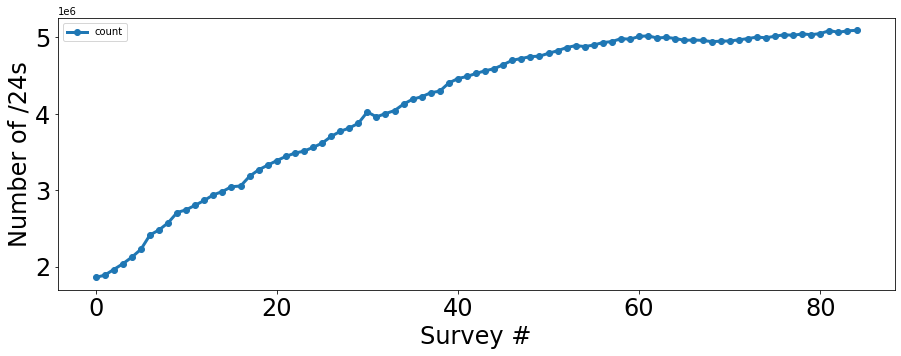

In [31]:
subnet_df = pd.read_csv('subnet_count_new.csv')
fig, ax = plt.subplots(figsize=(15,5), nrows=1, ncols=1)
subnet_df.plot.line(x='survey', y='count', ax=ax, style='-o', lw=3)
ax.xaxis.set_tick_params(labelsize=24)
ax.yaxis.set_tick_params(labelsize=24)
ax.set_ylabel('Number of /24s', fontsize=24)
ax.set_xlabel('Survey #', fontsize=24)

### Average number of responsive IPv4s per subnet over time

Text(0.5, 0, 'Survey #')

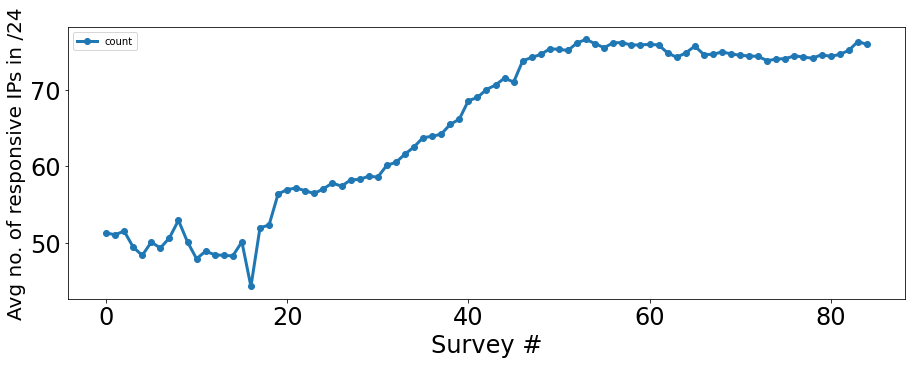

In [30]:
ip_count_df = pd.read_csv('avg_ip_count_in_subnet.csv')
fig, ax = plt.subplots(figsize=(15,5), nrows=1, ncols=1)
ip_count_df.plot.line(x='survey', y='count', ax=ax, style='-o', lw=3)
ax.xaxis.set_tick_params(labelsize=24)
ax.yaxis.set_tick_params(labelsize=24)
ax.set_ylabel('Avg no. of responsive IPs in /24', fontsize=20)
ax.set_xlabel('Survey #', fontsize=24)

### Chnages in ping response across surveys  
- We next look at how ping responses evolve over time. Do IP addresses exhibit ay patterns in their response? 
- To understand how responses change, we define a change score as follows:   
changeScore(ip, n\_surveys) =  abs(survey\_n - survey_(n-1)) + abs(survey_(n-1) - survey_(n-2)) + ...   
- We compute the change score for the 6 most recent surveys, i.e., there can be a maximum of five changes. 
- We then average the change score for the IPs in the /24.  
- At a high level, 35\% of /24s don't see any change to the responses from the IPs contained in them.  
- Of those 35\% of /24s, >99\% of them don't have any IPs that respond to any of the 6 surveys. 

In [54]:
response_change_subnet_df = pd.read_csv('ip_reponse_change.csv')


In [69]:
print('Fraction of /24s with no change', len(response_change_subnet_df[response_change_subnet_df['f0_']==0])/ len(response_change_subnet_df))

Fraction of /24s with no change 0.34560234770738896


### /24s with changes to response across surveys

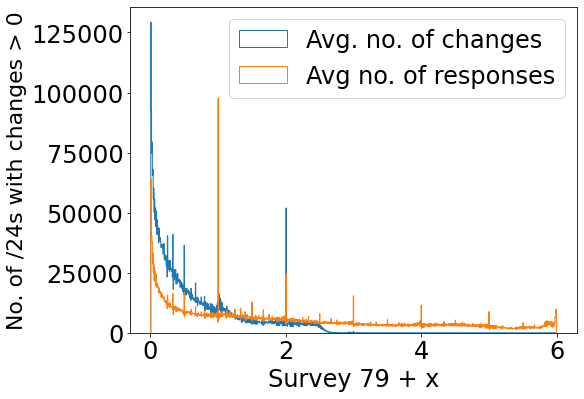

In [59]:
fig, ax = plt.subplots(figsize=(8,6), nrows=1, ncols=1)
response_change_subnet_df[response_change_subnet_df['f0_']>0].plot.hist(bins=1000, ax = ax, histtype='step')
ax.xaxis.set_tick_params(labelsize=24)
ax.yaxis.set_tick_params(labelsize=24)
ax.set_ylabel('No. of /24s with changes > 0', fontsize=22)
ax.set_xlabel('Survey 79 + x', fontsize=24)
ax.legend(['Avg. no. of changes', 'Avg no. of responses'], fontsize=24)

- On further investigation, we find that there are very few /24's with a change score of 5. 
- The IPs corresponding to these /24s exhibit a flipflopping response pattern.  
![IP Responses](response_changes.png)

### Zero change /24s  
For those /24s that experienced no change, we want to see if it was either because none of the IPs responded, or because all of them responded. 

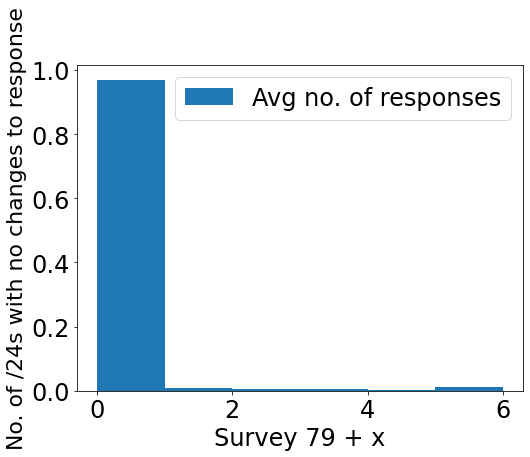

In [71]:
fig, ax = plt.subplots(figsize=(8,6), nrows=1, ncols=1)
response_change_subnet_df[response_change_subnet_df['f0_']==0]['f1_'].plot.hist(bins=6, ax = ax, density=True)
ax.xaxis.set_tick_params(labelsize=24)
ax.yaxis.set_tick_params(labelsize=24)
ax.set_ylabel('No. of /24s with no changes to response', fontsize=22)
ax.set_xlabel('Survey 79 + x', fontsize=24)
ax.legend([ 'Avg no. of responses'], fontsize=24)